## Volatility Estimation With LSTM RNN -  Keras Implementation

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import newaxis
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


#### True Range

In [2]:
path = 'GOOG.csv'
df = pd.read_csv(path)
df['rangepct'] = ((df.High - df.Low))/(df.Close.shift(1))
df = df['rangepct'].iloc[1:]

### Dataset Preprocessing - Many to One Format
#####  Input [p1 ,p2, p3 ,p4, p5] --> Output [p6]
#####  Input [p2, p3, p4, p5, p6] --> Output [p7]
##### Input [p3, p4 ,p5, p6, p7] --> Output [p8]

In [3]:
lbr = 5 # look back range
train_pct_split = 0.85

def data_split(df):
    df = df.values.reshape(-1,1)
    train_size = int(len(df) * train_pct_split)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

def scale_data(train, test):
    scalar = MinMaxScaler()
    train, test = scalar.fit_transform(train), scalar.fit_transform(test)
    return train, test

def create_dataset(dataset, lbr):
    X, Y = [], []
    for i in range(len(dataset)-lbr-1):
        append_set = dataset[i:(i+lbr), 0]
        X.append(append_set)
        Y.append(dataset[i + (lbr-(lbr-1)), 0])
    return np.array(X), np.array(Y)

def format_input_data(train, test):
    train = train[:,:,newaxis]
    test = test[:,:,newaxis]
    return train, test

### Build Model

In [4]:
batch_size = 100
epochs = 40
validation_size = 0.1
dropout = 0.1
loss = 'mse'

def build_model(lbr, loss, optimizer, dropout, activation):
    model = Sequential()
    model.add(LSTM(100,batch_input_shape=(None,lbr,1), return_sequences=True))
    
    model.add(Dropout(dropout))
    model.add(LSTM(1,return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.add(Activation(activation))
    model.compile(loss=loss,optimizer=optimizer)
    return model

### Fit Model and Plot Loss

In [5]:
def model_eval(trainX,trainY, model):
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore, np.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore, np.sqrt(testScore)))


def fit_plot_loss(model, trainX, trainY, testX, testY, batch, epoch, v_split):
    
    plt.plot(model.fit(trainX,
                       trainY,
                       batch_size=batch,
                       epochs=epoch,
                       validation_split=v_split
                      ).history['loss'])
    plt.show()
    
    model_eval(trainX,trainY, model)

    trainPred = model.predict(testX)
    
    return trainPred

Train on 2692 samples, validate on 300 samples
Epoch 1/40
2692/2692 [==============================] - 1s 482us/step - loss: 0.0133 - val_loss: 0.0045
Epoch 2/40
2692/2692 [==============================] - 0s 99us/step - loss: 0.0079 - val_loss: 0.0027
Epoch 3/40
2692/2692 [==============================] - 0s 94us/step - loss: 0.0061 - val_loss: 0.0016
Epoch 4/40
2692/2692 [==============================] - 0s 91us/step - loss: 0.0045 - val_loss: 0.0014
Epoch 5/40
2692/2692 [==============================] - 0s 94us/step - loss: 0.0045 - val_loss: 0.0015
Epoch 6/40
2692/2692 [==============================] - 0s 92us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 7/40
2692/2692 [==============================] - 0s 91us/step - loss: 0.0043 - val_loss: 0.0016
Epoch 8/40
2692/2692 [==============================] - 0s 92us/step - loss: 0.0040 - val_loss: 0.0015
Epoch 9/40
2692/2692 [==============================] - 0s 89us/step - loss: 0.0038 - val_loss: 0.0015
Epoch 10/40
2692/2692 [==

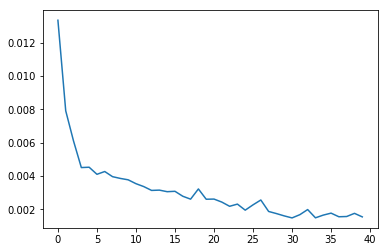

Train Score: 0.00067 MSE (0.02582 RMSE)
Test Score: 0.00189 MSE (0.04348 RMSE)


In [6]:

train, test = data_split(df)
train, test = scale_data(train, test)
trainX, trainY = create_dataset(train, lbr)
testX, testY = create_dataset(test, lbr)
trainX, testX = format_input_data(trainX, testX)

preds = fit_plot_loss(build_model(lbr,loss,'adam', dropout,'linear'),
                      trainX, trainY, testX, testY,
                      batch_size, epochs, validation_size
                     )

### Plot Predictions vs Test Data

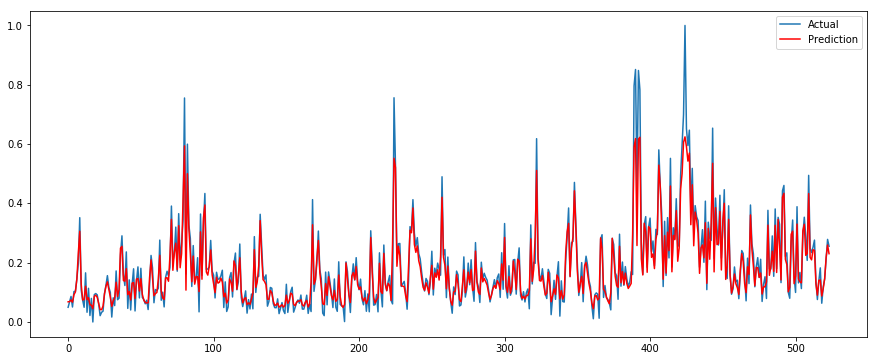

In [7]:
def plot_predictions(trainPred, testY):
    plt.figure(figsize=(15,6))
    plt.plot(range(len(testY)),testY,)
    plt.plot(range(len(trainPred)),trainPred, c='r')
    plt.legend(['Actual', 'Prediction'])
    plt.show()
    
plot_predictions(preds, testY)

### Benchmark Dummy Predictions 
#### Mean Prediction (moving average)

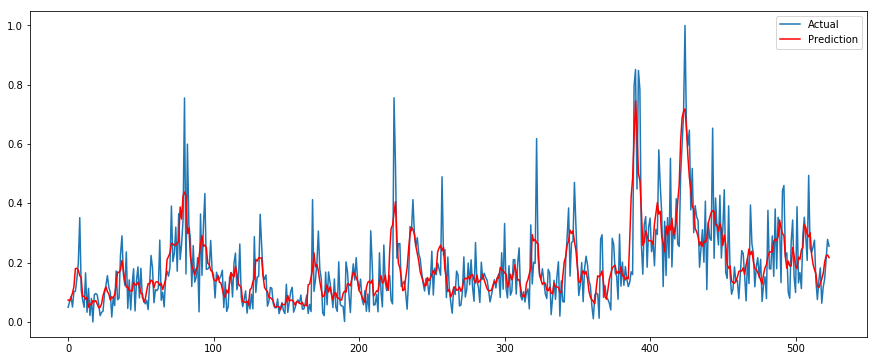

Mean Dummy Score: (0.06271 RMSE)


In [8]:
def dummy_mean(testX,testY):    
    bm_test = pd.DataFrame(data=testX.reshape(testX.shape[0],testX.shape[1]))
    bm_testX = bm_test.mean(axis=1)

    plot_predictions(bm_testX, testY)

    mse = pd.DataFrame({'test':bm_testX, 'label':testY})
    mse['squared error'] = (mse.label-mse.test)**2
    print('Mean Dummy Score: (%.5f RMSE)' % (np.sqrt(mse['squared error'].mean()/2)))
dummy_mean(testX,testY)